In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
import random

from tqdm import tqdm

from xgboost import XGBRegressor, XGBRanker
#from sklearn.xgboost import XGBRegressor

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, HistGradientBoostingClassifier, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.utils import resample
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, GroupKFold

In [2]:
def score_predict(X_test, y_test, pred):

    df = X_test.copy()
    df['true_y'] = y_test
    df['pred_y'] = pred

    match = sum((df.groupby('srch_id')['true_y'].idxmax() == df.groupby('srch_id')['pred_y'].idxmax()) & (df.groupby('srch_id')['true_y'].max() > 1))

    score = match / df['srch_id'].nunique()
    return score

In [4]:
# data = pd.read_csv('data/train_train.csv')

train_data = pd.read_csv('data/train_train_FE.csv')
train_data.drop('Unnamed: 0', axis=1, inplace=True)

train_data.drop('date_time', axis = 1, inplace=True)
#train_data.drop('prob_searchclick', axis = 1, inplace=True)

train_data['target'] = train_data['click_bool'] + 4* train_data['booking_bool']
train_data['target'].loc[train_data['target'].isna()] = int(0)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_74800/946108548.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['target'].loc[train_data['target'].isna()] = int(0)


In [5]:
test_data = pd.read_csv('data/train_test_FE.csv')
test_data.drop('Unnamed: 0', axis=1, inplace=True)

test_data.drop('date_time', axis = 1, inplace=True)
test_data['target'] = test_data['click_bool'] + 4* test_data['booking_bool']
test_data['target'].loc[test_data['target'].isna()] = int(0)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_74800/2496549599.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['target'].loc[test_data['target'].isna()] = int(0)


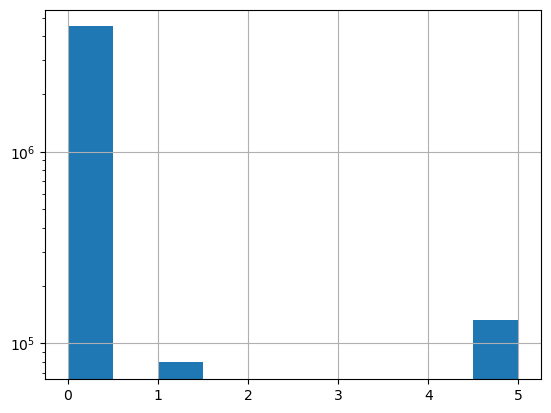

In [7]:
train_data['target'].hist()
plt.yscale('log')

In [8]:
# data.sort_values(['srch_id', 'target'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])
# ids = data['srch_id'].unique()

In [9]:
# train_ids = random.sample(list(ids), k = int(0.95* len(ids)))
# test_ids = set(ids) - set(train_ids)

In [10]:
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['booking_bool'].mean(), on = 'prop_id', rsuffix = '_mean')
# data = data.join(data.loc[data['srch_id'].isin(train_ids)].groupby('prop_id')['click_bool'].mean(), on = 'prop_id', rsuffix = '_mean')

In [11]:
# train_data = data.loc[data['srch_id'].isin(train_ids)]
# test_data = data.loc[data['srch_id'].isin(test_ids)]

In [12]:
# # get search ids with any booking
# ids_train = train_data['srch_id'].loc[train_data['booking_bool'] == 1].unique()
# # use only the searches that resulted in a booking
# train_data = train_data.loc[train_data['srch_id'].isin(ids)]
# # only use properties that are being booked
# props = train_data['prop_id'].loc[train_data['booking_bool'] == 1].unique()
# data = train_data.loc[train_data['prop_id'].isin(props)]

In [ ]:
#undersample non bookings
X_under, y_under = resample(train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).loc[train_data['target'] < 1], train_data['target'].loc[train_data['target'] < 1]
                                      , n_samples= 1* sum(data['target'] >= 1), replace=False)

In [15]:
# X_bal = pd.concat([X_under, train_data.drop(['true_rank', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                       , axis=1).loc[train_data['target'] >= 1]])

# y_bal = y_under
# y_bal = y_bal.append(train_data['target'].loc[train_data['target'] >= 1])

X_bal = train_data.drop(['click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1)
y_bal = train_data['target']


(array([4500138.,       0.,   79348.,       0.,       0.,       0.,
              0.,       0.,       0.,  131452.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

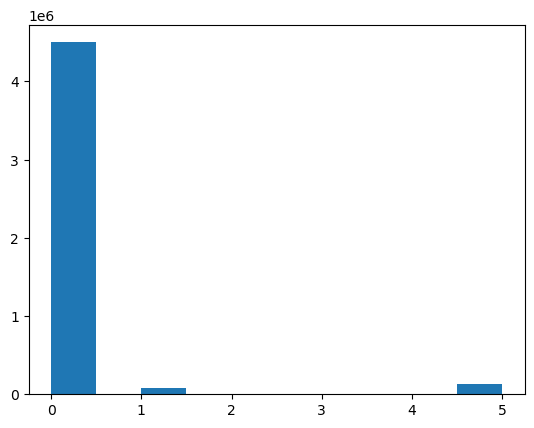

In [16]:
plt.hist(y_bal)

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal)

# X_train, X_test, y_train, y_test = train_test_split(data.drop(['booking_bool_mean', 'click_bool_mean', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
#                                        , axis=1), data['target'])
#X_train, y_train = X_bal, y_bal

In [18]:
# much better than just replacing with 0
# X_train = X_train.fillna(-9999)
# baseline = GradientBoostingRegressor(n_estimators = 100, max_leaf_nodes=None, max_depth=3, random_state=42)

#baseline = HistGradientBoostingRegressor(random_state=42)
#baseline = GradientBoostingRegressor(random_state=42)
#baseline = AdaBoostRegressor(random_state=42)

#baseline = XGBRegressor(n_estimators = 500, random_state = 42, objective= 'rank:ndcg@5')
baseline = XGBRanker(n_estimators = 100, random_state = 42, objective= 'rank:ndcg', eval_metric = 'ndcg@5-')

In [19]:
# hyper param tuning
# param_dist = {'min_samples_split' : [2, 10_000], 'max_depth' : [3, 15]}
# hp_search = HalvingRandomSearchCV(baseline, param_dist, min_resources=50_000).fit(X_train, y_train)

In [20]:
# hp_search.best_params_

In [21]:
groups = X_bal.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

baseline.fit(X_bal.drop(['srch_id'], axis = 1),y_bal, group = groups)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg@5-', feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, objective='rank:ndcg', predictor=None, ...)

In [ ]:
# pred = baseline.predict(data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target'], axis=1).fillna(-9999))

In [ ]:
#mean_squared_error(data['target'], pred)

In [ ]:
# pred_test = baseline.predict(X_test.drop(['srch_id'], axis=1).fillna(-9999))
# print('MSE', mean_squared_error(y_test, pred_test))

# score = score_predict(X_test, y_test, pred_test)
# print('score', score)

In [22]:
test_data['pred_score'] = baseline.predict(test_data.drop(['srch_id', 'click_bool', 'gross_bookings_usd', 'booking_bool', 'position', 'target']
                                      , axis=1).fillna(-9999))

ValueError: Feature shape mismatch, expected: 79, got 62

In [ ]:
print('MSE', mean_squared_error(test_data['target'], test_data['pred_score']))

MSE 3.66653517783853


In [ ]:
test_data['pred_rank'] = test_data.groupby('srch_id')['pred_score'].rank(ascending=False).astype(int)

In [ ]:
# scoring with ndcg
mean_ndcg = 0
counter = 0
for id in tqdm(test_ids):
    if len(test_data['true_rank'].loc[test_data['srch_id'] == id]) > 1:
        ndcg = ndcg_score([test_data['true_rank'].loc[test_data['srch_id'] == id].astype(int).to_numpy()],
                        [test_data['pred_score'].loc[test_data['srch_id'] == id].to_numpy()], k = 5)

    mean_ndcg += ndcg
    if ndcg < 1.0:
        counter +=1

mean_ndcg = mean_ndcg/len(test_ids)

100%|██████████| 9990/9990 [00:04<00:00, 2377.16it/s]


In [ ]:
mean_ndcg

0.4521572842557021

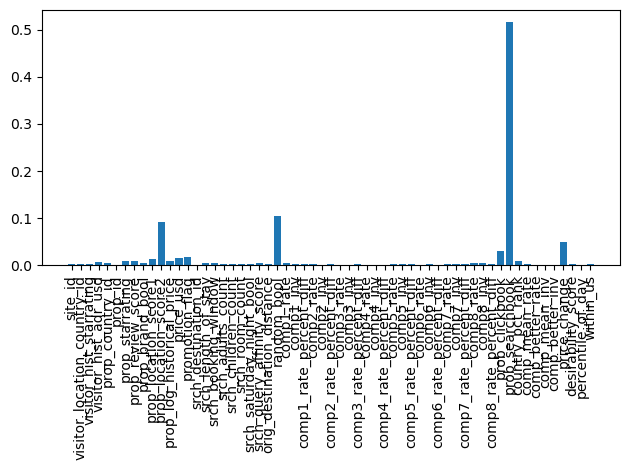

In [ ]:
plt.bar(range(len(baseline.feature_importances_)), baseline.feature_importances_)
plt.figsize= (4,20)
# plt.xlabel(baseline.get_booster().feature_names, rotation = 90)
plt.xticks(range(len(baseline.feature_importances_)), baseline.get_booster().feature_names,rotation = 90)
plt.tight_layout()
plt.show()


## Predict the test dataset and bring it into requested format

In [ ]:
comp_data = pd.read_csv('data/FE_test_set.csv')
comp_data.drop('Unnamed: 0', axis=1, inplace=True)

# test_data = pd.read_csv('data/test_set_VU_DM.csv')
comp_data.drop('date_time', axis = 1, inplace=True)

In [ ]:
comp_data.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,in_train,country_pct_rank,comp_mean_rate,comp_better_rate,comp_mean_inv,comp_better_inv,price_change,desirability_score,percentile_of_day,within_us
0,1,24,216,NaN,NaN,219,3180,3,4.5,1,...,1.0,0.75,0.059901,1,0.072788,1,-0.221882,0.001371,0.644213,-1
1,546,5,219,NaN,NaN,219,3180,3,4.5,1,...,1.0,0.75,0.059901,1,0.072788,1,128.000000,0.001371,0.007616,2
2,3382,18,129,NaN,NaN,219,3180,3,4.5,1,...,1.0,0.75,0.059901,1,0.072788,1,-0.065658,0.001371,0.548611,-1
3,5549,31,219,NaN,NaN,219,3180,3,4.5,1,...,1.0,0.75,0.059901,1,0.072788,1,-0.293316,0.001371,0.848437,2
4,5883,5,219,NaN,NaN,219,3180,3,4.5,1,...,1.0,0.75,0.059901,1,0.072788,1,-0.206163,0.001371,0.251331,2


In [ ]:
set(comp_data.columns) - set(baseline.get_booster().feature_names)

{'in_train', 'srch_id'}

In [ ]:
comp_data['prediction'] = baseline.predict(comp_data.drop(['srch_id', 'in_train'], axis=1).fillna(-9999))

# test_data['prediction'] = baseline.predict(test_data.drop(['srch_id', 'date_time'], axis=1).fillna(-9999))

In [ ]:
# sort values for final format
comp_data.sort_values(['srch_id', 'prediction'], axis=0, inplace=True, ignore_index=True, ascending=[True, False])

In [ ]:
filename = 'data/predictions/prediction'+str(datetime.now())+'.csv'
comp_data[['srch_id', 'prop_id']].to_csv(filename, index=False)